In [0]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import mean_absolute_error

import pdb


In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import seaborn as sns

In [0]:
# Functions of creating synthetic time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [0]:
# Functions of creating feature and label
def t_window(x, size, shift=None, stride=1):
    try:
        nd = len(size)
    except TypeError:
        size = tuple(size for i in x.shape)
        nd = len(size)
    if nd != x.ndimension():
        raise ValueError("size has length {0} instead of "
                         "x.ndim which is {1}".format(len(size),
                                                      x.ndimension()))
    out_shape = tuple(xi-wi+1 for xi, wi in zip(x.shape, size)) + size
    if not all(i > 0 for i in out_shape):
        raise ValueError("size is bigger than input array along at "
                         "least one dimension")
    out_strides = x.stride() * 2
    return t.as_strided(x, out_shape, out_strides)


def t_apply(func, M):
    res = [func(m) for m in t.unbind(M, dim=0)]
    return res


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    '''
    series [t.tensor]: dataset
    '''
    if(isinstance(series, np.ndarray)):
        dataset = t.from_numpy(series)
    dataset = t_window(dataset, window_size + 1, shift=1)
    dataset = t_apply(lambda window: (window[:-1], window[-1:]), dataset)
    # batch_size: how many samples per batch to load (default: 1)
    dataset = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    return dataset

In [0]:
# Design structure of deep neural network model
# Ref: https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
class Net(nn.Module):

    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.num_layers = 2
        # hidden_size – The number of features in the hidden state h
        self.hidden_size = hidden_size
        # input_size: The number of expected features in the input `x`
        # batch_first: the input and output tensors are provided as `(batch, seq, feature)`
        self.SimpleRNN = nn.RNN(input_size=1, hidden_size=self.hidden_size,
                                num_layers=self.num_layers, batch_first=True)
        # In PyTorch, RNN doesn't have ``return_sequences```
        # Ref: https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#RNN
        # layer_input_size = input_size if layer == 0 else hidden_size * num_directions
        # num_layers: Number of recurrent layers. E.g., setting ``num_layers=2`` 
        # would mean stacking two RNNs together to form a `stacked RNN`, 
        # with the second RNN taking in outputs of the first RNN and computing the final results.
        # Note: **output** of shape `(seq_len, batch, num_directions * hidden_size)`
        self.Dense = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        # Ref: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
        batch_size = x.size(0)
        x = t.unsqueeze(x, 2)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.SimpleRNN(x, hidden)
        output = self.Dense(output[:, -1, :])  # only take last one of output
        result = output * 100.0
        return result

    def init_hidden(self, batch_size):
        hidden = t.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
      

In [0]:
class History():
    """
    The `History` object gets returned by the `fit` method of models.
    """

    def __init__(self, metric_name):
        self.history = {'loss': [], metric_name: []}

    def append_log(self, log_key, log_value):
        self.history[log_key].append(log_value)

In [0]:
# Define metric and learning algorithms.
# As well as train(fit) and predict.
class Sequential():

    def __init__(self, model):
        self.model = model
        self.metric = None
        self.optimizer = None
        self.loss = None

    def t_compile(self, loss, metric, optimizer):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def t_fit(self, dataset, epochs, callbacks=[], verbose=0):
        history = History('{0}'.format(self.metric.__name__))
        if(callbacks != []):
            scheduler = LambdaLR(self.optimizer, lr_lambda=callbacks)
        for epoch in range(epochs):
            running_loss = 0.0
            Outputs_epoch = []
            Labels_epoch = []
            for i, data in enumerate(dataset, 0):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                Loss = self.loss(outputs, labels)
                Loss.backward()
                self.optimizer.step()
                running_loss += Loss.item()
                Outputs_epoch.append(outputs)
                Labels_epoch.append(labels)
            if(callbacks != []):
                scheduler.step()
            history.append_log('loss', running_loss / i)
            history.append_log(self.metric.__name__,
                               self.metric(t.cat(Labels_epoch).detach().numpy(),
                                           t.cat(Outputs_epoch).detach().numpy()))
        print('Finished Training')
        return history

    def t_predict(self, dataset):
        return self.model(dataset)

In [0]:
# Plot results
def openfig(Figsize=(10, 6)):
    plt.figure(figsize=Figsize)


def savefig(filename):
    plt.savefig('{0}_{1}.png'.format(prefix_name, filename))
    plt.clf()

In [0]:
t.manual_seed(1729)
np.random.seed(1729)
matplotlib.use('Agg')
sns.set()
plt.switch_backend('agg')
prefix_name = 'SPW3L2'

In [0]:
# Config of creating time series
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [0]:
# Create the time series
series = baseline + trend(time, slope) + seasonality(time, period=365,
                                                     amplitude=amplitude)

In [0]:
# Update with noise
series += noise(time, noise_level, seed=42)

In [0]:
# Train and validate split
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [0]:
# Config of creating feature and label
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Create feature and label of training set
train_set = windowed_dataset(x_train, window_size, batch_size=128,
                             shuffle_buffer=shuffle_buffer_size)

In [0]:
# Model build
# hidden_size – The number of features in the hidden state h
model = Sequential(Net(hidden_size=40))

In [0]:
# his will be called at the callback at the end of each epoch. 
# What it will do is change the learning rates to a value based on the epoch number. 
lr_schedule = [lambda epoch: 10.0 ** (epoch / 20)]
# learning rate measures how much the current situation affects the next step
# momentum measures how much past steps affect the next step.
optimizer = optim.SGD(model.model.parameters(), lr=1e-8, momentum=0.9)
model.t_compile(loss=nn.SmoothL1Loss(), optimizer=optimizer, metric=mean_absolute_error)

In [0]:
# Model train
# Callbacks are a way to interact with the optimization process.
history = model.t_fit(train_set, epochs=100, callbacks=lr_schedule)

Finished Training


[1e-08, 0.0001, 0, 30]

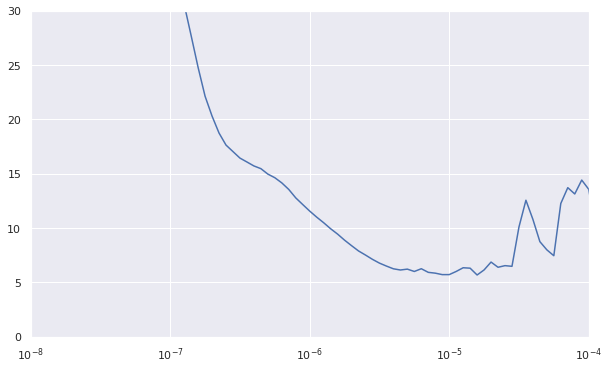

In [0]:
# Plot
# The y-axis shows the loss for that epoch and the x-axis shows us the learning rate
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
openfig()
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])


In [0]:
savefig('1_resultsLoss_learningRates')

<Figure size 432x288 with 0 Axes>

In [0]:
print(lrs[np.argmin(history.history['loss'])])

1.584893192461114e-05


In [0]:
# Second Model
t.manual_seed(1729)
np.random.seed(1729)

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size=128,
                           shuffle_buffer=shuffle_buffer_size)

In [0]:
model2 = Sequential(Net(hidden_size=40))
optimizer = optim.SGD(model2.model.parameters(), lr=5e-5, momentum=0.9)
model2.t_compile(loss=nn.SmoothL1Loss(), optimizer=optimizer, metric=mean_absolute_error)
history2 = model2.t_fit(dataset, epochs=400)

Finished Training


In [0]:
forecast2 = []
for time in range(len(series) - window_size):
    forecast_feature = series[time:time + window_size][np.newaxis]
    forecast2.append(model2.t_predict(t.from_numpy(forecast_feature)))

In [0]:
forecast2 = forecast2[split_time-window_size:]
results = t.cat(forecast2).detach().numpy()[:, 0]

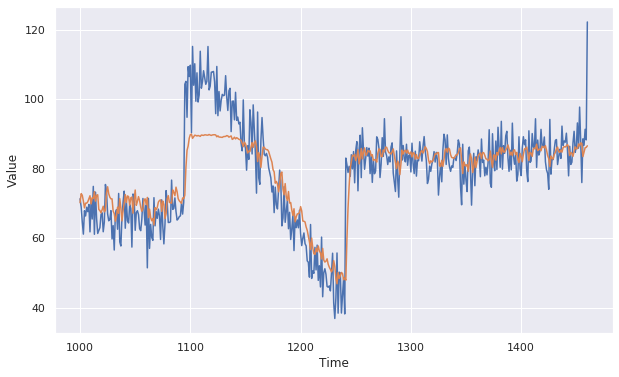

In [0]:
openfig()
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
savefig('2_forecast')

<Figure size 432x288 with 0 Axes>

In [0]:
print(mean_absolute_error(x_valid, results))

6.0509


In [0]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
mae = history2.history['mean_absolute_error']
loss = history2.history['loss']

In [0]:
epochs = range(len(loss))  # Get number of epochs

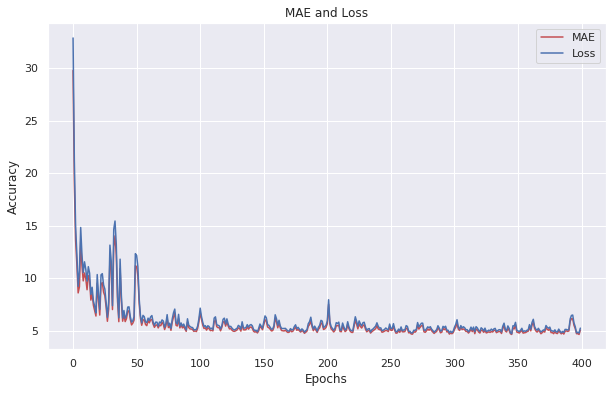

In [0]:
# Plot MAE and Loss
openfig()
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

In [0]:
savefig('3_retrieve_training_mae_loss')

<Figure size 432x288 with 0 Axes>

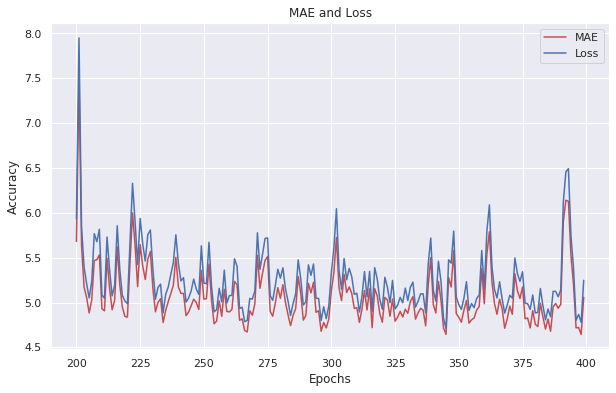

In [0]:
# Plot Zoomed MAE and Loss
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]
openfig()
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

In [0]:
savefig('4_retrieve_training_mae_loss_zoomin')

<Figure size 432x288 with 0 Axes>